# Segementing unintentionally funny URLs

In [1]:
import numpy as np
from collections import Counter
from arsenal import colors
from arsenal.iterextras import take

from hypergraphs.semirings.sampling.lazy2 import Sample
from hypergraphs.semirings import LazySort
from hypergraphs.semirings.float import Float
from hypergraphs.apps.segmentation import segmentation
from arsenal.nb import psource

In [2]:
psource(segmentation)

In [12]:
def fit():
    "Very simple model based on unigram frequency"
    freq = Counter()
    for line in open('unigrams.txt'):
        w, x = line.lower().strip().split()
        freq[w] = float(x)
    z = sum(freq.values())
    freq = {w: freq[w]/z for w in freq}
    return freq.get

In [13]:
examples = [
    'penisland',
    #'powergenitalia',
    #'bobwehadababyitsaboy',
    'speedofart',
    'expertsexchange',
    #'whorepresents',
]

K = 5
score = fit()
for x in examples:
    print()
    print(colors.light.yellow % f'{x}')
    
    Z = segmentation(x, score, Float)
    print()
    print('top-K')    
    for y in take(K, segmentation(x, score, LazySort)):
        print(y.score/Z, y.data)
        
    print()
    print('samples')        
    for _, y in take(K, segmentation(x, score, Sample)):
        print(y)



penisland

top-K
0.5143256593983477 ['penis', 'land']
0.45207604125212736 ['pen', 'island']
0.027873132685929416 [['penis', 'l'], 'and']
0.0036460304048695704 [['pen', 'is'], 'land']
0.0013213750410641435 [['p', 'en'], 'island']

samples
['pen', 'island']
['pen', 'island']
['penis', 'land']
['penis', 'land']
['pen', 'island']

speedofart

top-K
0.9948943598425257 [['speed', 'of'], 'art']
0.0033231183428176388 ['speedo', 'fart']
0.0009894486441325765 [[['speed', 'of'], 'a'], 'rt']
0.00035244286773342435 [['speedo', 'f'], 'art']
0.00019960965350590237 [['speedo', 'far'], 't']

samples
[['speed', 'of'], 'art']
[['speed', 'of'], 'art']
[['speed', 'of'], 'art']
[['speed', 'of'], 'art']
[['speed', 'of'], 'art']

expertsexchange

top-K
0.9969224044043288 ['experts', 'exchange']
0.0017432330281829994 [['expert', 'sex'], 'change']
0.0011263750641583288 [['expert', 's'], 'exchange']
0.0001957233201327399 [['experts', 'ex'], 'change']
6.9768261034718806e-06 [['experts', 'e'], 'xchange']

samples

### Posterior distribution over segments

In [14]:
class Segment:
    def __init__(self, x, i=None, j=None):
        self.x = x
        self.i = i or 0
        self.j = j or len(self.x)
    def __len__(self):
        return self.j - self.i
    def __hash__(self):
        return hash(str(self))
    def __str__(self):
        return str(self.x[self.i:self.j])
    def __eq__(self, other):
        return str(self) == str(other) 
    def __lt__(self, other):
        return str(self) < str(other)
    def __getitem__(self, ij):
        assert isinstance(ij, slice) and ij.step is None
        return Segment(self.x, ij.start, ij.stop)
    def __repr__(self):
        return f'Segment({self.x[self.i:self.j]}, {self.i}, {self.j})'
    def __iter__(self):
        return iter((self.x, self.i, self.j))

In [61]:
from hypergraphs.semirings.expr import Expr, backprop, Sum, Prod, weight, maxtimes

x = Segment('penisland')
#x = Segment('speedofart')
#x = Segment('expertsexchange')
#x = Segment('powergenitalia')
Z = segmentation(x, score, Expr)
z = weight(Z)

In [62]:
m = {}
adj = backprop(Z)
for y in adj:
    if isinstance(y, (Sum, Prod)): continue
    s, (_,i,j) = y.args
    m[i,j] = s*weight(adj[y])/z

In [63]:
for i,j in sorted(m, key=lambda ij: -m[ij]):
    print(f'{m[i,j]:.4f} {x[i:j]}')
    if m[i,j] < .0001: break

0.5423 penis
0.5180 land
0.4561 pen
0.4536 island
0.0283 and
0.0281 l
0.0039 is
0.0013 p
0.0013 en
0.0002 pe
0.0002 n
0.0002 isl
0.0000 d


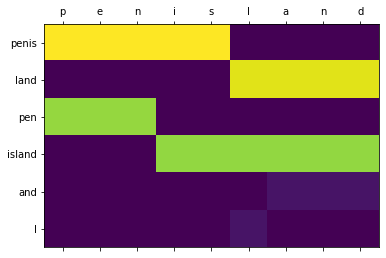

In [64]:
import pylab as pl
n = len(x)
S = []
segments = []
for i,j in sorted(m, key=lambda ij: -m[ij]):
    p = np.zeros(n)
    p[i:j] = m[i,j]
    if m[i,j] < .01: break
    S.append(p)
    segments.append(str(x[i:j]))

pl.matshow(S)
pl.xticks(range(n), labels=list(x.x))
pl.yticks(range(len(segments)), labels=list(segments));

### Posterior decoding

In [65]:
def posterior(segment):
    assert isinstance(segment, Segment) and segment.x is x.x
    _,i,j = segment
    return m.get((i,j), 0)
Z = segmentation(x, posterior, Expr)

In [66]:
posterior_decode = maxtimes(Z)
posterior_decode

(Expr(0.5422796261386904, Segment(penis, 0, 5)) * Expr(0.5179895918885105, Segment(land, 5, 9)))